In [1]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(SCRIPT_DIR)

import tensorflow as tf
import numpy as np
import pandas as pd
import gpflow

from tueplots import bundles

from rcgp.rcgp import RCGPR
from rcgp.w import IMQ

from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib.pyplot as plt
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
DATA_PATH = os.path.join(SCRIPT_DIR,'experiments/data')
RESULT_PATH = os.path.join(SCRIPT_DIR,'experiments/results/Flashcrash')
FILE_PATH = os.path.join(DATA_PATH,'Flashcrash/DJI.txt')

In [3]:
DJI = pd.read_csv(FILE_PATH, header = None)
DJI.columns =['date', 'open', 'high', 'low', 'close']
DJI['date'] = pd.to_datetime(DJI['date'], infer_datetime_format=True)
flash_crash_dji = DJI[(DJI['date'].dt.date.astype(str) == '2013-04-23')]

/var/folders/k2/0gsms3d50h5djv0xk65zk1yh0000gn/T/ipykernel_12996/4261480462.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  DJI['date'] = pd.to_datetime(DJI['date'], infer_datetime_format=True)


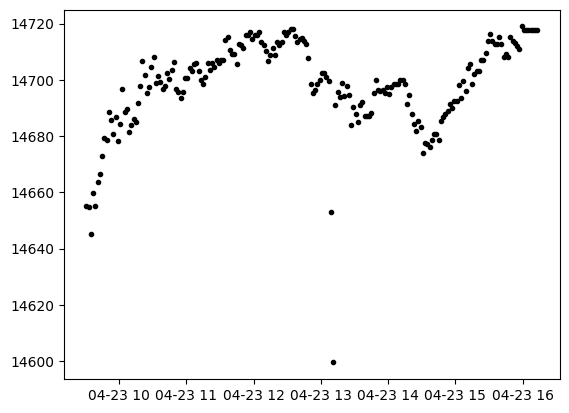

In [257]:
data = flash_crash_dji['open'].values.reshape(-1,1)[1::2]
dates = flash_crash_dji['date'].values.reshape(-1,1)[1::2]

arr1inds = dates[:,0].argsort()
data = data
dates = dates

plt.plot(dates,data,'k.')

In [258]:
class MyScaler:
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.median(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        '''To transform mean'''
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        '''To transform standard deviation'''
        return x*self.std

In [259]:
class RobustScaler2(RobustScaler):

    def inverse_transform_mean(self, x):
        '''To transform mean'''
        return x*self.scale_ + self.center_

    def inverse_transform_std(self, x):
        '''To transform standard deviation'''
        return x*self.scale_

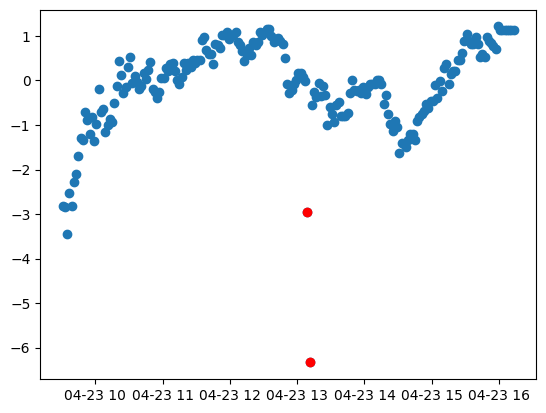

In [312]:
dates_float = dates.astype(np.float64)
x_scaler = StandardScaler()
y_scaler = MyScaler()
dates_normalised = x_scaler.fit_transform(dates_float)
y_scaler.fit(data)
data_normalised = y_scaler.transform(data)
plt.scatter(dates,data_normalised)
plt.scatter(dates[[109,110]],data_normalised[[109,110]], color = 'r')

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 181.02140463324417
        x: [-2.928e+00  7.505e-02 -1.675e+00]
      nit: 18
      jac: [-9.016e-06 -9.018e-06 -6.358e-07]
     nfev: 20
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.73138
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.05212
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.17171


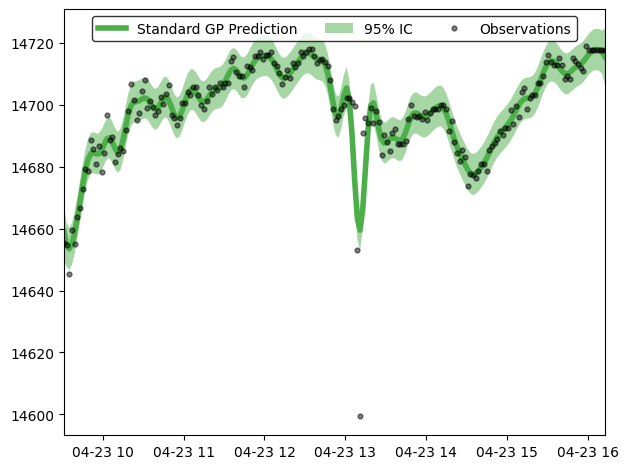

In [275]:
standard_gp = gpflow.models.GPR(
    (dates_normalised, data_normalised),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=0.01,variance = 0.01),
    noise_variance = 0.01
)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(standard_gp.training_loss_closure(), standard_gp.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(standard_gp, "notebook")

f_mean, f_var = standard_gp.predict_f(dates_normalised, full_cov=False)

f_std = np.sqrt(f_var)

f_mean, f_std = y_scaler.inverse_transform_mean(f_mean), y_scaler.inverse_transform_std(f_std)


plt.plot(dates[:,0], f_mean, c=CB_color_cycle[2], lw=4, label= 'Standard GP Prediction')
plt.fill_between(
    dates[:,0],
    f_mean[:,0] - 1.96 * f_std[:,0],
    f_mean[:,0] + 1.96 * f_std[:,0],
    facecolor= CB_color_cycle[2],
    alpha=0.5,
    label='95% IC')
#plt.plot(dates, standard_gp.mean_function(dates_normalised))

plt.plot(dates, data, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.xlim(dates[0], dates[-1])
plt.legend(ncol=4, frameon=True, shadow=False, loc=9, edgecolor='k')
plt.tight_layout()

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 133.5300991552386
        x: [-3.294e+00  1.741e+00]
      nit: 16
      jac: [-1.439e-06  2.972e-07]
     nfev: 43
     njev: 43
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


name,class,transform,prior,trainable,shape,dtype,value
RTGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.90294
RTGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.03645
RTGPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.17171


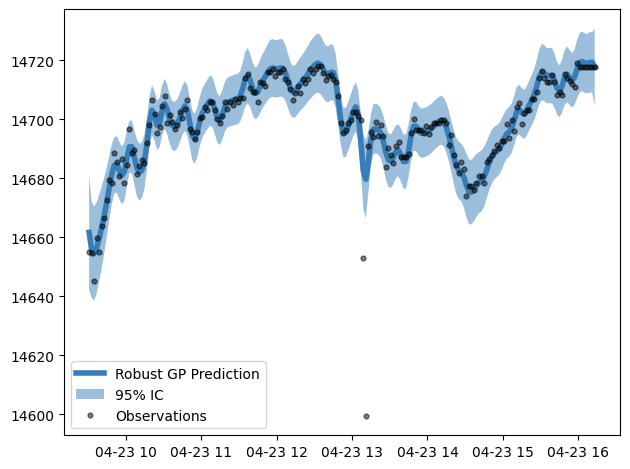

In [278]:
model = RCGPR(
    (dates_normalised, data_normalised),
    kernel=gpflow.kernels.SquaredExponential(),
    weighting_function=IMQ(1.5),
    noise_variance=standard_gp.likelihood.variance)

gpflow.set_trainable(model.likelihood.variance, False)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(model, "notebook")

f_mean_dsm, f_var_dsm = model.predict_f(dates_normalised, full_cov=False)

f_std_dsm = np.sqrt(f_var_dsm)

f_mean_dsm, f_std_dsm = y_scaler.inverse_transform_mean(f_mean_dsm), y_scaler.inverse_transform_std(f_std_dsm)

plt.plot(dates[:,0], f_mean_dsm, c=CB_color_cycle[0], lw=4, label= 'Robust GP Prediction')
plt.fill_between(
    dates[:,0],
    f_mean_dsm[:,0] - 1.96 * f_std_dsm[:,0],
    f_mean_dsm[:,0] + 1.96 * f_std_dsm[:,0],
    facecolor= CB_color_cycle[0],
    alpha=0.5,
    label='95% IC')

plt.plot(dates, data, 'k.', ms=7, alpha=0.5, label = 'Observations')
plt.legend()
plt.tight_layout()

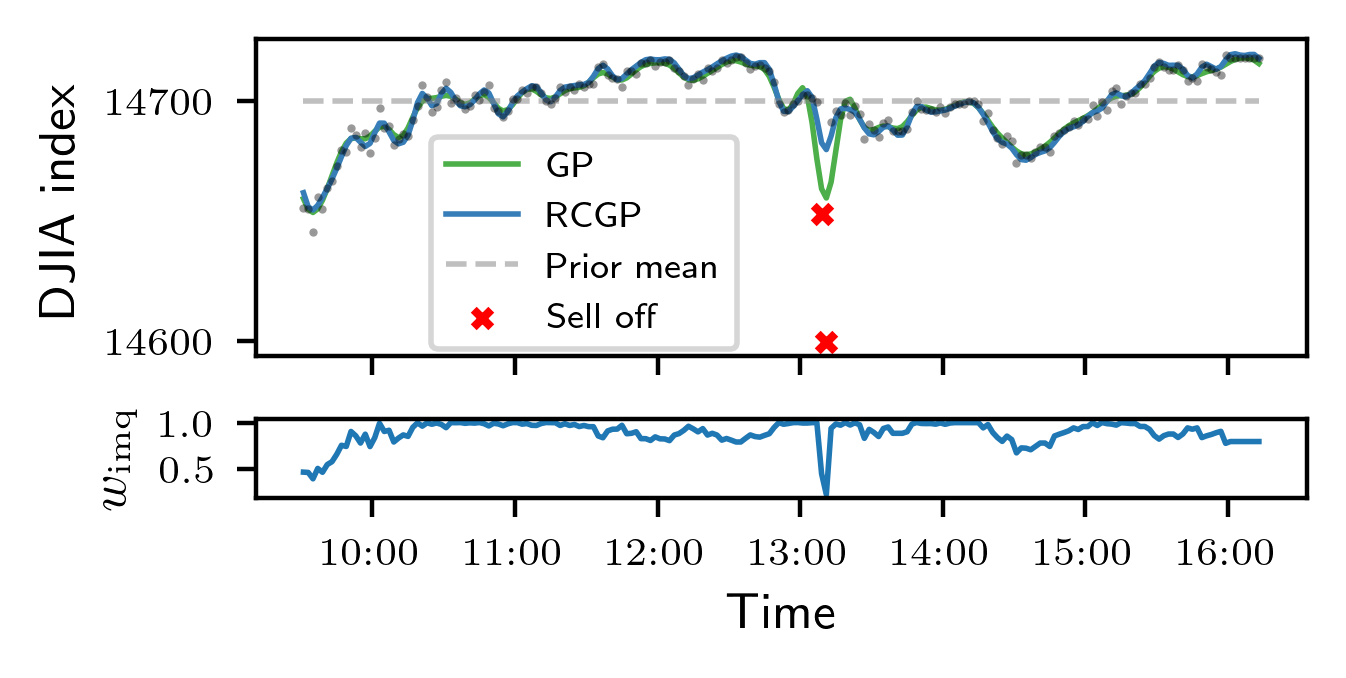

In [344]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib as mpl
with plt.rc_context(bundles.aistats2023()):
    fig, ax = plt.subplots(nrows= 2, sharex = True , figsize= (3.25, 1.58),dpi = 400, gridspec_kw={'height_ratios': [4,1]})
    ax[0].plot(dates[:,0], f_mean[:,0], c=CB_color_cycle[2], lw=1, label= 'GP')

    ax[0].plot(dates[:,0], f_mean_dsm[:,0], c=CB_color_cycle[0], lw=1, label= 'RCGP')
    ax[0].hlines(np.median(data),dates[0],dates[-1], label='Prior mean', lw=1, ls='--', alpha=0.5, color='grey')

    mask = np.ones(data.shape, bool)
    mask[[109,110]] = False
    ax[0].set_ylabel('DJIA index')
    ax[0].plot(dates[mask], data[mask], 'k.', ms=1, alpha=0.4)
    ax[0].scatter(dates[[109,110]], data[[109,110]], marker = 'x', alpha=1, color= 'r', s=10, label = 'Sell off')
    ax[1].xaxis.set_major_locator(mdates.HourLocator())
    date_form = DateFormatter("%H:%M")
    ax[1].xaxis.set_major_formatter(date_form)
    ax[1].set_xlabel('Time')
    ax[1].plot(dates, model.weighting_function.W(dates_normalised, data_normalised), lw=1)
    ax[1].set_ylabel(r'$w_{\mathrm{imq}}$')

    ax[0].legend(loc='upper left', bbox_to_anchor=(0.15,0.75), fontsize=6.5)
    fig.savefig('figures/flashcrash.pdf', format="pdf", bbox_inches= "tight")